In [1]:
%matplotlib inline
from __future__ import division, print_function
import sys,os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

sys.path.append(os.path.join(os.getcwd(),'../..'))

import dltk.core.modules as modules
from dltk.models.segmentation.unet import ResUNET
from dltk.core.modules import dice_loss

plt.rcParams['image.cmap'] = 'gray'

imwidth=256
imheight=256
numImgs=20
trainSteps=20

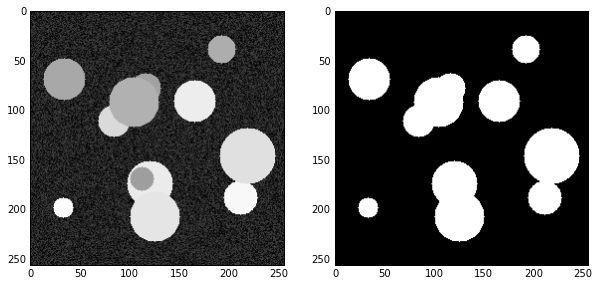

In [2]:
def createTestImage(width,height,numObjs=12,radMax=30):
    '''Return a noisy 2D image with `numObj' circles and a 2D mask image.'''
    image=np.zeros((width,height))
    
    for i in range(numObjs):
        x=np.random.randint(radMax,width-radMax)
        y=np.random.randint(radMax,height-radMax)
        rad=np.random.randint(10,radMax)
        spy,spx = np.ogrid[-x:width-x, -y:height-y]
        circle=(spx*spx+spy*spy)<=rad*rad
        image[circle]=np.random.random()*0.5+0.5
    
    norm=np.random.uniform(0,0.25,size=image.shape)
    
    return np.maximum(image,norm),(image>0).astype(float)


def plotPair(im1,im2):
    '''Convenience function for plotting two images side-by-side.'''
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(im1)
    ax[1].imshow(im2)
    
im,mask=createTestImage(imwidth,imheight)
plotPair(im,mask)

(20, 1, 256, 256, 16)
INFO:tensorflow:feat_scale_1 shape (20, 1, 128, 128, 32)
(20, 1, 128, 128, 32)
INFO:tensorflow:feat_scale_2 shape (20, 1, 64, 64, 64)
(20, 1, 64, 64, 64)
INFO:tensorflow:Building upsampling for scale 1 with x ([20, 1, 64, 64, 64]) x_up ([20, 1, 128, 128, 32]) stride ((1, 2, 2))
INFO:tensorflow:up_1 shape (20, 1, 128, 128, 32)
(20, 1, 128, 128, 32)
INFO:tensorflow:Building upsampling for scale 0 with x ([20, 1, 128, 128, 32]) x_up ([20, 1, 256, 256, 16]) stride ((1, 2, 2))
INFO:tensorflow:up_0 shape (20, 1, 256, 256, 16)
(20, 1, 256, 256, 16)
INFO:tensorflow:last conv shape (20, 1, 256, 256, 2)
(20, 1, 256, 256, 16)
INFO:tensorflow:feat_scale_1 shape (20, 1, 128, 128, 32)
(20, 1, 128, 128, 32)
INFO:tensorflow:feat_scale_2 shape (20, 1, 64, 64, 64)
(20, 1, 64, 64, 64)
INFO:tensorflow:Building upsampling for scale 1 with x ([20, 1, 64, 64, 64]) x_up ([20, 1, 128, 128, 32]) stride ((1, 2, 2))
INFO:tensorflow:up_1 shape (20, 1, 128, 128, 32)
(20, 1, 128, 128, 32)
INFO:

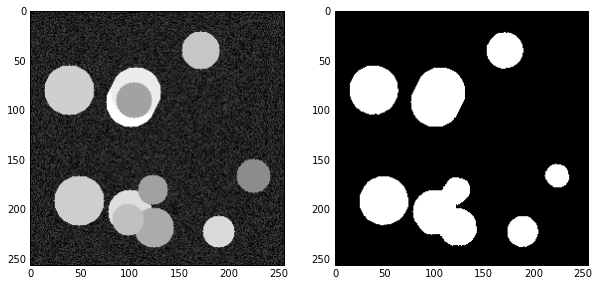

In [9]:
xtrain=np.zeros((numImgs,1,imwidth,imheight,1))
ytrain=np.zeros((numImgs,1,imwidth,imheight,2))

def fillTrainData():
    for i in range(numImgs):
        im,mask=createTestImage(imwidth,imheight)
        xtrain[i,0,:,:,0]=im
        ytrain[i,0,:,:,0]=1-mask
        ytrain[i,0,:,:,1]=mask
    
with tf.Graph().as_default():
    x=tf.placeholder(tf.float32, xtrain.shape)
    y_=tf.placeholder(tf.int32, ytrain.shape)
    
    net = ResUNET(num_classes=2,num_residual_units=3,
                  filters=(16, 32, 64),
                  strides=((1,1,1), (1,2,2), (1,2,2)))

    y = net(x)['logits']
    
    # define dice coefficient using Jaccard formulation
    eps=1e-5
    prediction = tf.contrib.layers.softmax(y)
    preds_one = prediction[...,1]  
    labels_one = tf.cast(y_[...,1],tf.float32)
    intersection = tf.reduce_sum(preds_one * labels_one)
    l = tf.reduce_sum(preds_one * preds_one)
    r = tf.reduce_sum(labels_one * labels_one)
    loss = -(2. * intersection + eps) / (l + r + eps)
    
    trainop = tf.train.AdamOptimizer(1e-4).minimize(loss)

    soft_config = tf.ConfigProto(allow_soft_placement=True)
    soft_config.gpu_options.allow_growth = True
    with tf.Session(config=soft_config) as sess:
        sess.run(tf.global_variables_initializer())
        
        # perform training steps
        for step in range(trainSteps):
            fillTrainData()
            for _ in range(10):
                trainop.run(feed_dict={x: xtrain, y_: ytrain})
            
        # evaluate result with new generated data
        fillTrainData()
        ypred=net(x, is_training=False)['y_']
        test=ypred.eval(feed_dict={x: xtrain})
        
        # plot prediction
        plotPair(np.squeeze(xtrain[0]),np.squeeze(test[0]))         